![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/10.3.ZeroShot_Clinical_Relation_Extraction.ipynb)

# 10.3. Zero-shot Clinical Relation Extraction Model


### Zero-shot Relation Extraction to extract relations between clinical entities with no training dataset
This release includes a zero-shot relation extraction model that leverages `BertForSequenceClassificaiton` to return, based on a predefined set of relation candidates (including no-relation / O), which one has the higher probability to be linking two entities.

The dataset will be a csv which contains the following columns: `sentence`, `chunk1`, `firstCharEnt1`, `lastCharEnt1`, `label1`, `chunk2`, `firstCharEnt2`, `lastCharEnt2`, `label2`, `rel`.

For example, let's take a look at this dataset (columns `chunk1`, `rel`, `chunk2` and `sentence`):

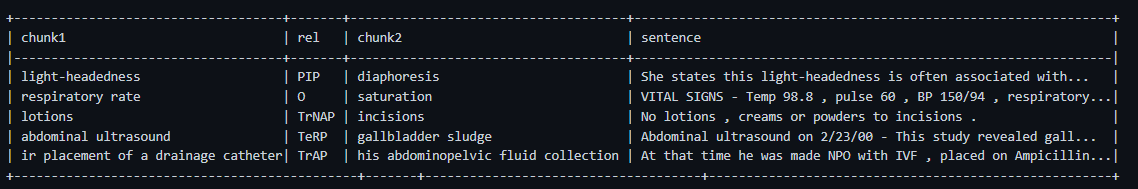


The relation types (TeRP, TrAP, PIP, TrNAP, etc...) are described [here](https://www.i2b2.org/NLP/Relations/assets/Relation%20Annotation%20Guideline.pdf)

Let's take a look at the first sentence!

`She states this light-headedness is often associated with shortness of breath and diaphoresis occasionally with nausea`

As we see in the table, the sentences includes a `PIP` relationship (`Medical problem indicates medical problem`), meaning that in that sentence, chunk1 (`light-headedness`) *indicates* chunk2 (`diaphoresis`).

We set a list of candidates tags (`[PIP, TrAP, TrNAP, TrWP, O]`) and candidate sentences (`[light-headedness caused diaphoresis, light-headedness was administered for diaphoresis, light-headedness was not given for diaphoresis, light-headedness worsened diaphoresis]`), meaning that:

- `PIP` is expressed by `light-headedness caused diaphoresis`
- `TrAP` is expressed by `light-headedness was administered for diaphoresis`
- `TrNAP` is expressed by `light-headedness was not given for diaphoresis`
- `TrWP` is expressed by `light-headedness worsened diaphoresis`
- or something generic, like `O` is expressed by `light-headedness and diaphoresis`...

We will get that the biggest probability of is `PIP`, since it's phrase `light-headedness caused diaphoresis` is the most similar relationship expressing the meaning in the original sentence (`light-headnedness is often associated with ... and diaphoresis`)

## Colab Setup

In [ ]:
import json

from google.colab import files

license_keys = files.upload()

with open(list(license_keys.keys())[0]) as f:
    license_keys = json.load(f)

In [2]:
# Defining license key-value pairs as local variables
locals().update(license_keys)

# Adding license key-value pairs to environment variables
import os
os.environ.update(license_keys)

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.1.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

In [5]:
# if you want to start the session with custom params as in start function above
from pyspark.sql import SparkSession

def start(SECRET):
    builder = SparkSession.builder \
        .appName("Spark NLP Licensed") \
        .master("local[*]") \
        .config("spark.driver.memory", "16G") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.kryoserializer.buffer.max", "2000M") \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:"+PUBLIC_VERSION) \
        .config("spark.jars", "https://pypi.johnsnowlabs.com/"+SECRET+"/spark-nlp-jsl-"+JSL_VERSION+".jar")
      
    return builder.getOrCreate()

# spark = start(SECRET)

In [ ]:
import json
import os
from pyspark.ml import Pipeline,PipelineModel
from pyspark.sql import SparkSession

from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
import sparknlp_jsl
import sparknlp

import warnings
warnings.filterwarnings('ignore')

params = {"spark.driver.memory":"16G", 
          "spark.kryoserializer.buffer.max":"2000M", 
          "spark.driver.maxResultSize":"2000M"} 

spark = sparknlp_jsl.start(license_keys['SECRET'],params=params)

print ("Spark NLP Version :", sparknlp.version())
print ("Spark NLP_JSL Version :", sparknlp_jsl.version())

## Zero Shot Relation Extraction
Using the pretrained `re_zeroshot_biobert` model, available in Models Hub under the Relation Extraction category.




In [7]:
data = spark.createDataFrame(
    [["Paracetamol can alleviate headache or sickness. An MRI test can be used to find cancer."]]
).toDF("text")

In [ ]:
documenter = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("tokens")

sentencer = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentences")

words_embedder = WordEmbeddingsModel() \
    .pretrained("embeddings_clinical", "en", "clinical/models") \
    .setInputCols(["sentences", "tokens"]) \
    .setOutputCol("embeddings")

pos_tagger = PerceptronModel() \
    .pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["sentences", "tokens"]) \
    .setOutputCol("pos_tags")

ner_tagger = MedicalNerModel() \
    .pretrained("ner_clinical", "en", "clinical/models") \
    .setInputCols(["sentences", "tokens", "embeddings"]) \
    .setOutputCol("ner_tags")

ner_converter = NerConverter() \
    .setInputCols(["sentences", "tokens", "ner_tags"]) \
    .setOutputCol("ner_chunks")

dependency_parser = DependencyParserModel() \
    .pretrained("dependency_conllu", "en") \
    .setInputCols(["document", "pos_tags", "tokens"]) \
    .setOutputCol("dependencies")

re_ner_chunk_filter = RENerChunksFilter() \
    .setRelationPairs(["problem-test","problem-treatment"]) \
    .setMaxSyntacticDistance(4)\
    .setDocLevelRelations(False)\
    .setInputCols(["ner_chunks", "dependencies"]) \
    .setOutputCol("re_ner_chunks")

re_model = ZeroShotRelationExtractionModel \
    .pretrained("re_zeroshot_biobert", "en", "clinical/models")\
    .setRelationalCategories({
        "CURE": ["{{TREATMENT}} cures {{PROBLEM}}."],
        "IMPROVE": ["{{TREATMENT}} improves {{PROBLEM}}.", "{{TREATMENT}} cures {{PROBLEM}}."],
        "REVEAL": ["{{TEST}} reveals {{PROBLEM}}."]})\
    .setMultiLabel(False)\
    .setInputCols(["re_ner_chunks", "sentences"]) \
    .setOutputCol("relations")

pipeline = sparknlp.base.Pipeline() \
    .setStages([documenter, tokenizer, sentencer, words_embedder, pos_tagger, ner_tagger, ner_converter,
                dependency_parser, re_ner_chunk_filter, re_model])

In [9]:
model = pipeline.fit(data)
results = model.transform(data)

In [10]:
results\
    .selectExpr("explode(relations) as relation")\
    .show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|relation                                                                                                                                                                                                                                                                                                                                                              |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------